# DEMONSTRATIVE NOTEBOOK FOR THE USE OF PLANTCV IN DISEASE QUANTIFICATION IN WHEAT POWDERY MILDIEW 

This notebook represents a demonstrative guide to show a workflow that could be used for the quantitative analysis of leaf section images of wheat in inoculation essays with powdery mildiew. It's intended to show the logic behind the functions and approaches utilized. 
At the end of the notebook a "for" loop can be found which can be applied to a folder containing a set of images to obtain the optimized measurements and metrics described here.
Since the segmentation part of this workflow is done using the Naive Bayes Classifier that PlantCV has, the obtention of the PDF's from a training set is not in the scope of this notebook, but is a pre-requisite to have the .txt file with the PDF's in order to be able to performs the analysis shown here

In [6]:
import cv2
import os
import numpy as np
import sys
import csv
from IPython.display import clear_output
from plantcv import plantcv as pcv
from csv import writer

We set the debug parameters to "plot" so the output of the code is visible here in the notebook

In [11]:
pcv.params.debug = "plot"

# 1st - Image Upload

The image is in the same folder as this script/notebook. For demostrative purposes any image can be use, as long as it is from the same database, just change the name between ()

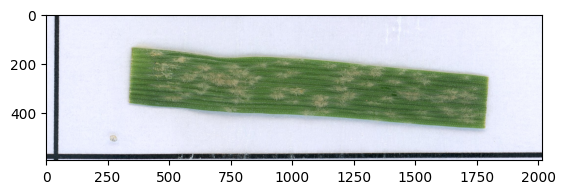

In [13]:
# Read in a color image
img, path, filename = pcv.readimage("BP_TRA1MMu_25072016_N4_THUN12X96224_6dpi_27.jpg")

# 2nd - Pixel classification

We use the previously created Probability Density Functions (PDFs) for the clasiffier to classify the pixels of the image according to the 3 classes we previously defined. The results show the three different classes pixels in this order, "normal plant tissue", "background" and "infection". Pixels for the given class are the white ones in the image.

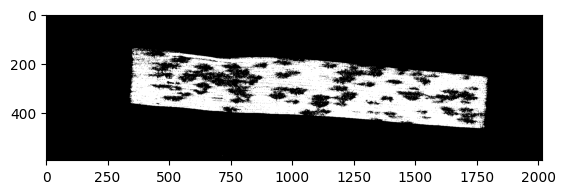

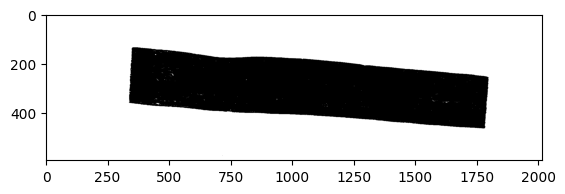

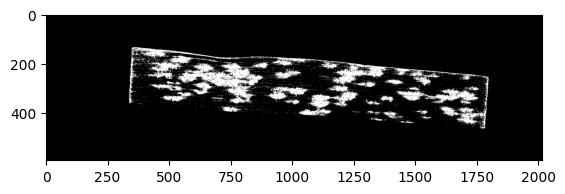

In [14]:
# Classify the pixels using the pdfs file previously created
masks = pcv.naive_bayes_classifier(img, pdf_file="naive_bayes_pdfs.txt")

# 3rd - False color image of the three classes

We plotted a false color image with a color for each of the classes, being Gray = Background, Red = Infection and Green = Leaf Tissue

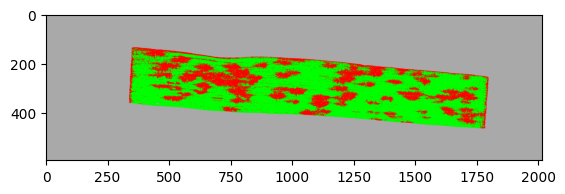

In [15]:
# Plot an image representing the classification
plotted = pcv.visualize.colorize_masks(masks=[masks['plant'], masks['infection'], masks['background']], 
                                       colors=['green', 'red', 'gray'])

As you can see there's some noise in these results, having a lot of missclassified pixels (false positives mostly) in the edges of the leaf cuttings and in some of the leaf striations. A way to see how serious is this is by using a completely healthy plant for the previous steps and using the following code for measuring the porcentage of infected area relative to the total plant area. Feel free to start the analysis from the beginning using a healthy image to see it.

In [16]:
#Now lets calculate the porcentage of disease plant given the whole plant
whole_leaf_area = np.count_nonzero(masks['plant']) + np.count_nonzero(masks['infection']) 
disease_percentage = np.count_nonzero(masks['infection']) /whole_leaf_area
print(disease_percentage)                                          

0.30776838084845176


If a healthy leaf section was used for the previous analysis the value will generally be around 5-3%, which is not a bad error margin, but could still be optimized

# 4th - Optimization of the classification using denoising

We use some denoising in order to reduce the amount of missclassified pixels and to obtain a more optimized classification. In this case we use the "fill" function to eliminate small cluster of pixels that are noise and then we merge those two new masks and invert them to have a filled third mask (healthy plant)

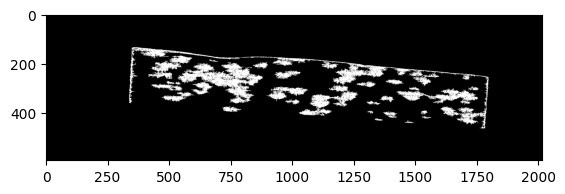

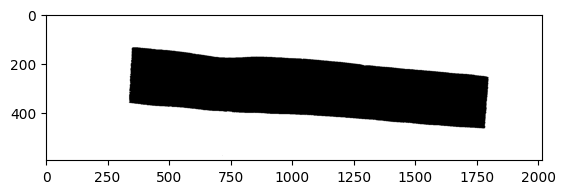

In [21]:
#We fill the infection mask and the background one
new_infection = pcv.fill(bin_img=masks['infection'], size=95)
new_background = pcv.fill(bin_img=masks['background'], size=10000)

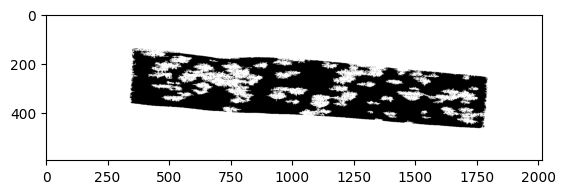

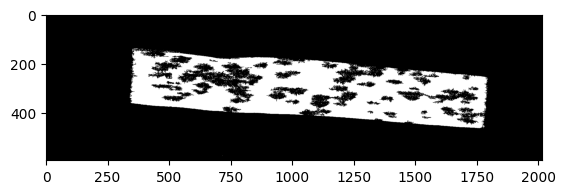

In [22]:
#Now we join those two binary images we just created and we invert them to have a new plant mask
joint_masks = pcv.logical_or(bin_img1=new_infection, bin_img2=new_background)
new_plant = pcv.invert(joint_masks)

To visualize the result we create the false color image with the representation of the classes

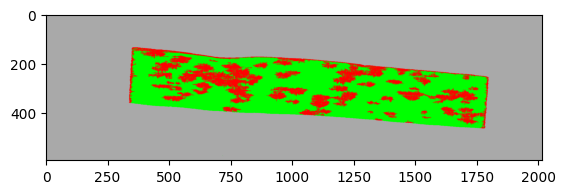

In [23]:
# Plot an image representing the classification (WITH THE FILLED IMAGE)
plotted = pcv.visualize.colorize_masks(masks=[new_plant, new_infection, new_background], 
                                       colors=['green', 'red', 'gray'])

It is obvious that this image have a lot less of noise and missclassified pixels than the one without the denoising. There are still some false positives, specially near the edges of the leaf cutting but less than in the previous one. A way of quantifying the difference is to calculate the infection percentage once again, but with this new masks

In [28]:
#Now lets calculate the porcentage of disease plant given the whole plant
whole_leaf_area = np.count_nonzero(new_plant) + np.count_nonzero(new_infection) 
new_disease_percentage = np.count_nonzero(new_infection) /whole_leaf_area
print(disease_percentage)                                          

0.2783621023299017


The value is gonna be smaller than the previous one that was calculated. If you want to quantify how much does this approach helps when handling false positives and artifacts in the image that could be missclassified as background use a picture with a healthy plant from the beginning of the analysis and compare 

# 5th - Further optimization

In [1]:
from PIL import Image

In [8]:
image = Image.open("BP_TRA1MMu_25072016_N4_THUN12X96224_6dpi_27.jpg")

In [12]:
width, height = image.size
print(width)
print(height)

2016
592


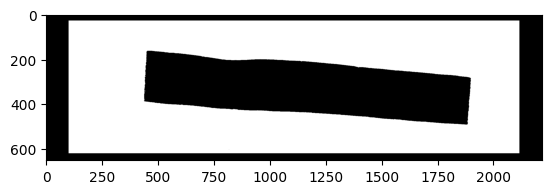

In [34]:
resize_img = resize(new_background, size=(2218, 651), interpolation=None)

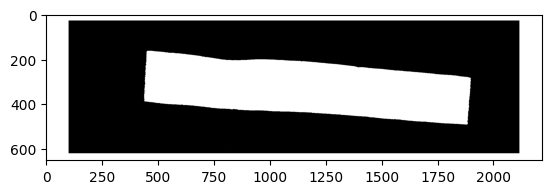

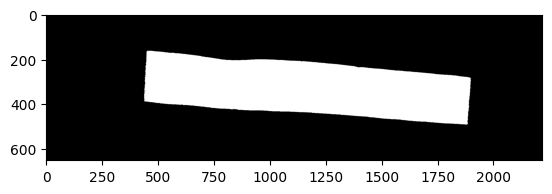

In [33]:
new_small_leaf = pcv.invert(resize_img)
new_small_leaf2 = pcv.fill(bin_img=new_small_leaf, size=300000)

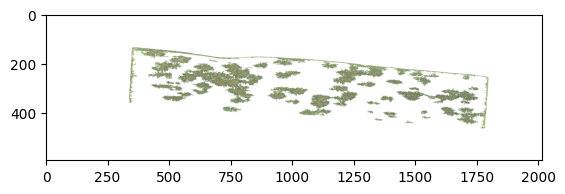

In [29]:
#apply the infection mask to the image to leave everything but the fungae
masked_colonies = pcv.apply_mask(img=img, mask=fill_image_infection, mask_color='white')

In [14]:
#and lets try to use the resized image to clear those edges
joint_masks2 = pcv.logical_or(bin_img1=fill_image_infection, bin_img2=resized_img_background)
new_plant_mask2 = pcv.invert(joint_masks)

error: OpenCV(3.4.9) ..\modules\core\src\arithm.cpp:229: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


In [ ]:
#Loop for doing all that in a folder
#A for loop to iterate over the img in the folder and obtain an .csv output with the
count = 0
image_folder = "C:/master_thesis_data/workbench/001_Pm_10K_training_set"
for file in os.listdir(image_folder):
    if file.endswith(".jpg"):
        file_name = str(file)
        file_path = "C:/master_thesis_data/workbench/001_Pm_10K_training_set/" + file_name
        img, path, filename = pcv.readimage(file_path)
        masks = pcv.naive_bayes_classifier(img, pdf_file="naive_bayes_pdfs.txt")
        fill_image_infection = pcv.fill(bin_img=masks['infection'], size=95)
        fill_image_background = pcv.fill(bin_img=masks['background'], size=10000)
        joint_masks = pcv.logical_or(bin_img1=fill_image_infection, bin_img2=fill_image_background)
        new_plant_mask = pcv.invert(joint_masks)
        whole_leaf_area = np.count_nonzero(new_plant_mask) + np.count_nonzero(fill_image_infection)
        disease_ratio = np.count_nonzero(masks['infection']) /whole_leaf_area
        input_csv = [disease_ratio, file_name]
        with open("output_infection_ratio.csv", 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(input_csv)
            f_object.close()
        clear_output()
        count = count + 1
        print(count)